In [84]:
import os
from glob import glob
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

from sklearn.metrics import roc_auc_score

In [85]:

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

In [86]:
logs_path = 'C:\\Users\\emace\\AImageLab\\SRV-Continual\\results\\canomaly\\logs'

In [87]:
for environment in glob(logs_path + '/**/*.pyd', recursive=True):
    with open(environment, 'r') as f:
        experiments = [literal_eval(line) for line in f.readlines()]

In [88]:
# usage example:  show_exp_images(experiments[0], True)
def show_exp_images(exp: dict, show_origins=False):
    print({k: exp[k] for k in exp if k not in ['logs', 'results', 'knowledge']})
    plt.style.use('dark_background')
    for task in exp['results']:
        cur_images = exp['results'][task]['images']
        fig, axs = plt.subplots(2, 5, figsize=(15, 8))
        fig.suptitle(f'TASK {task}', fontsize=30)
        for r, row in enumerate(axs):
            for c, cell in enumerate(row):
                idx = r*5 + c
                image = np.zeros((28, 28, 3), dtype=float)
                cell.set_title(cur_images[idx]['label'])
                orig = np.array(cur_images[idx]['original'][0])
                recon = np.array(cur_images[idx]['reconstruction'][0]).clip(0, 1)
                if show_origins:
                    image[:,:,1] = orig
                image[:,:,0] = recon
                image[:,:,2] = recon
                cell.imshow(image)
        plt.show()

task 0: 0.9848434883931401
task 1: 0.695556005282796
task 2: 0.8135422380128413
task 3: 0.7051793397032305
task 4: 0.5376544008271352
task 5: 0.5806235056892375
task 6: 0.6423691421149116
task 7: 0.49501359032127334
task 8: 0.46396925501649655
{'seed': 819869015, 'dataset': 'can-mnist', 'model': 'ae', 'optim': 'SGD', 'lr': 0.1, 'joint': False, 'batch_size': 16, 'n_epochs': 2, 'latent_space': 32, 'classes_per_task': 1, 'id': 'a72f9110-351c-40d5-aea6-9b0ad6db7238', 'timestamp': '2022-01-26 17:18:34.287679'}


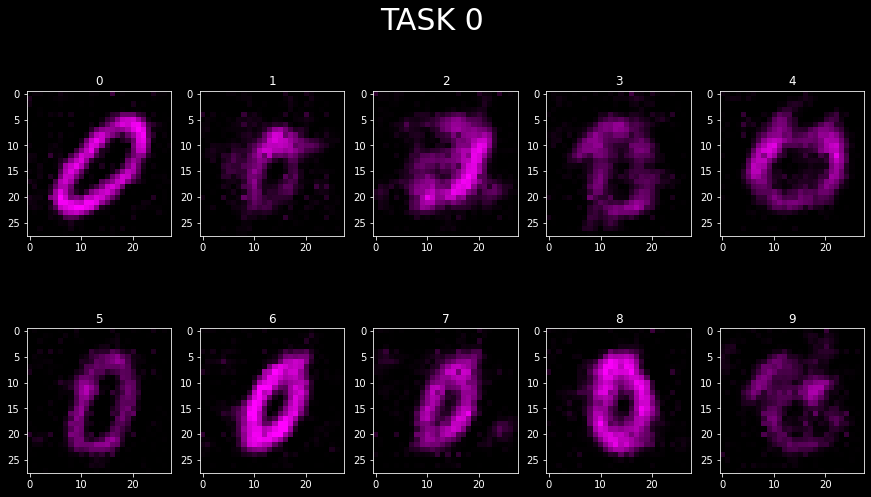

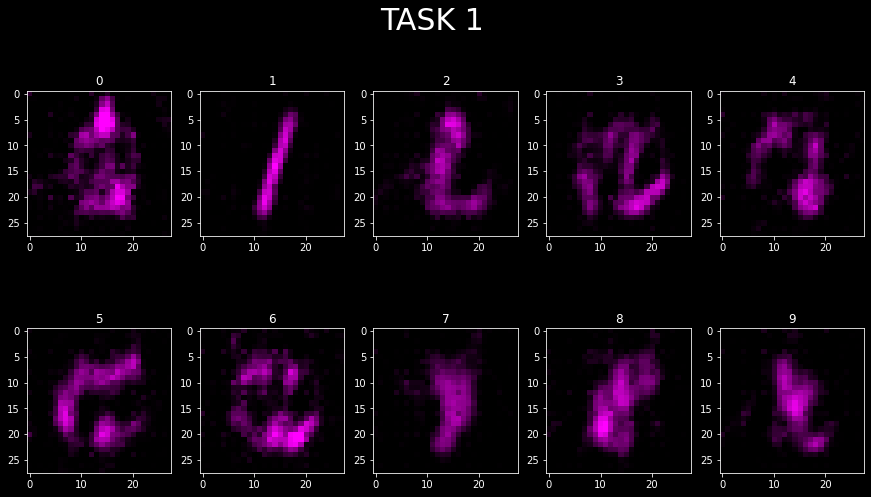

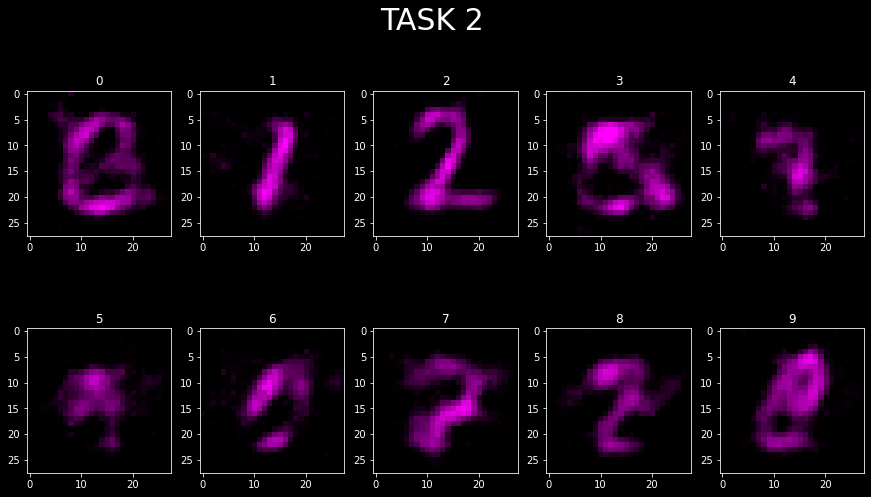

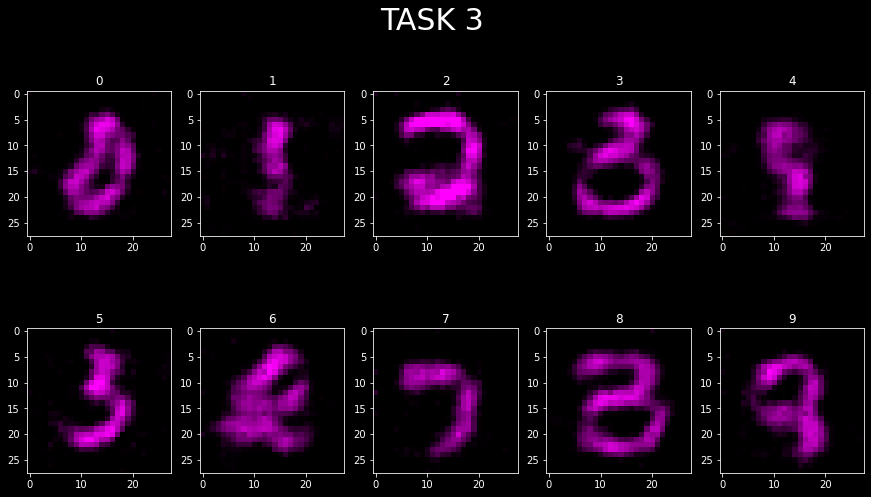

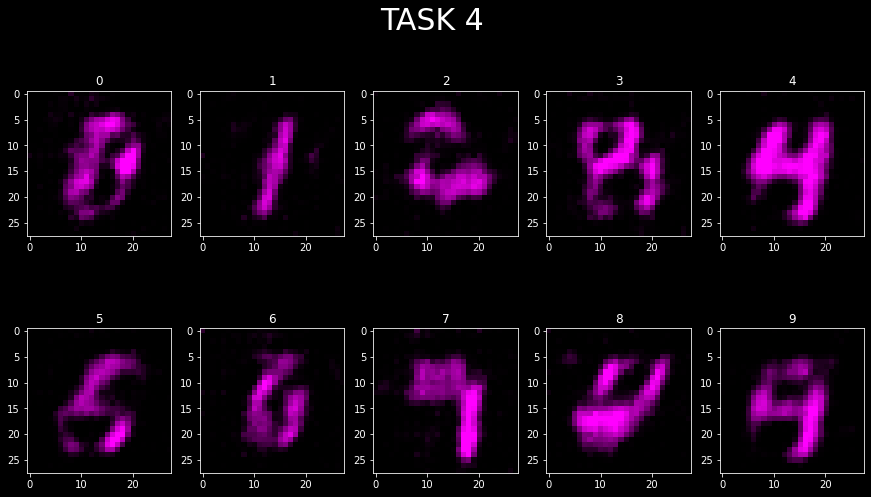

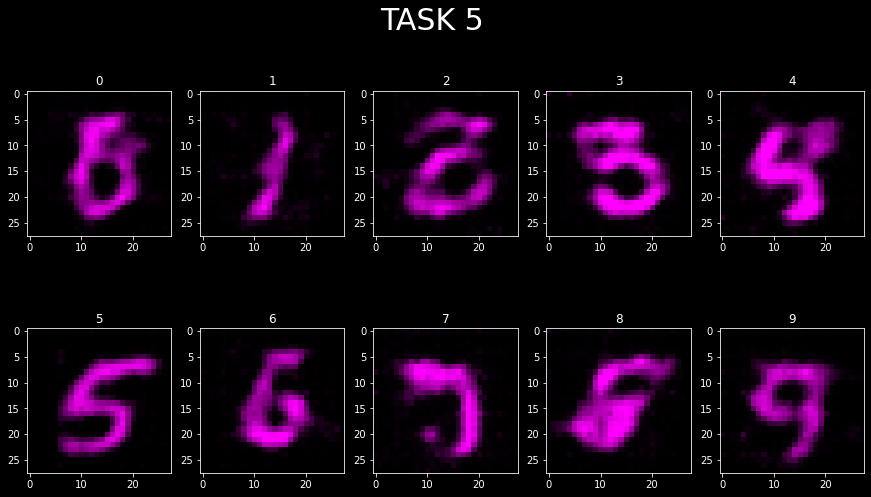

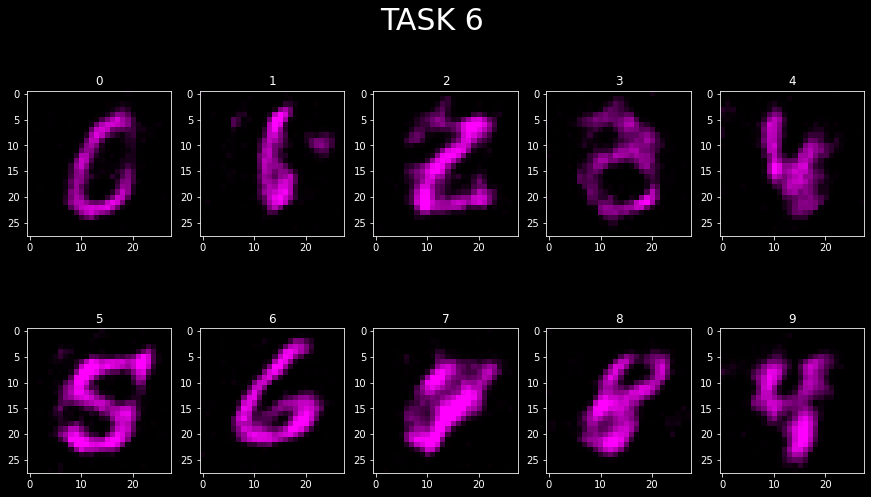

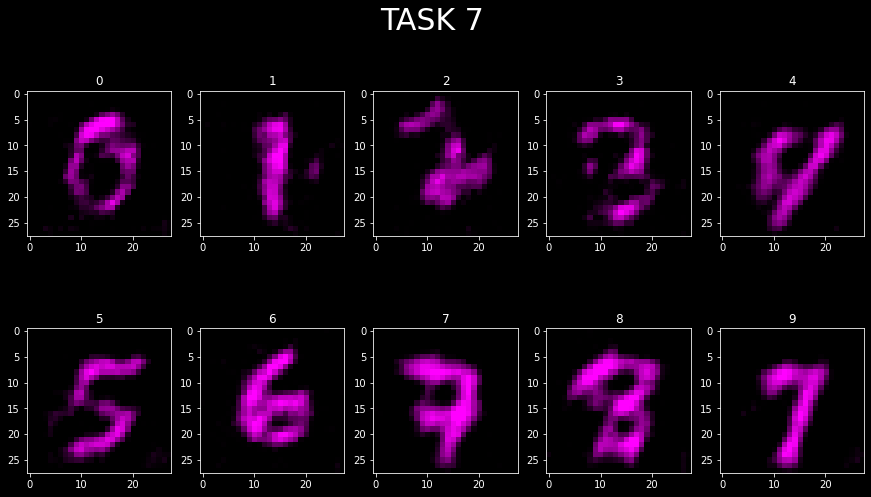

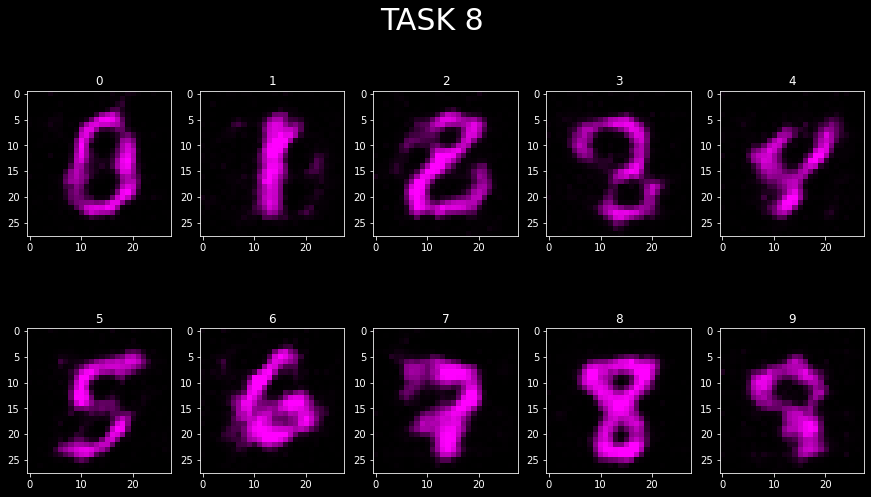

In [92]:
exp = experiments[1]
knowledge = []
for task in exp['results']:
    knowledge.extend(exp['knowledge'][task])
    targets = np.array(exp['results'][task]['targets'])
    scores = np.array(exp['results'][task]['rec_errs'])
    anomalies = np.logical_not(np.isin(targets, knowledge)).astype(int)
    auc = roc_auc_score(anomalies, scores)
    print(f'task {task}: {auc}')

show_exp_images(exp, False)

{'seed': 819869015, 'dataset': 'can-mnist', 'model': 'ae', 'optim': 'SGD', 'lr': 0.1, 'joint': False, 'batch_size': 16, 'n_epochs': 2, 'latent_space': 32, 'classes_per_task': 1, 'id': 'a72f9110-351c-40d5-aea6-9b0ad6db7238', 'timestamp': '2022-01-26 17:18:34.287679'}


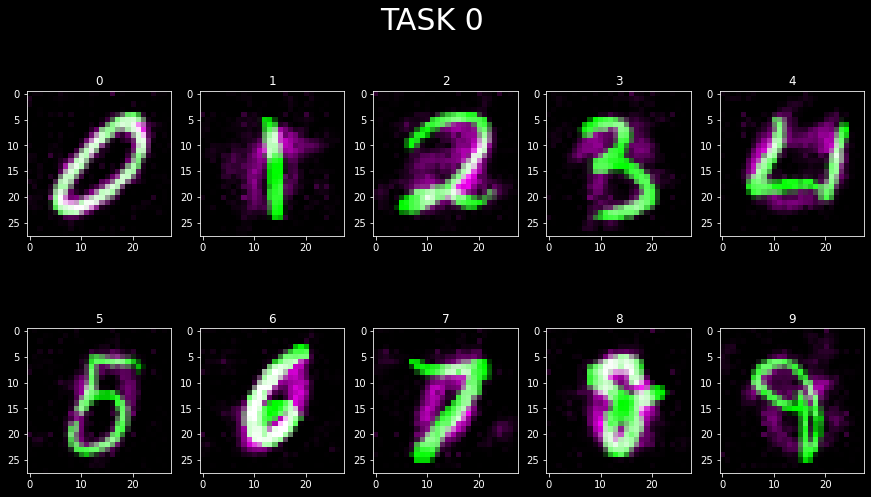

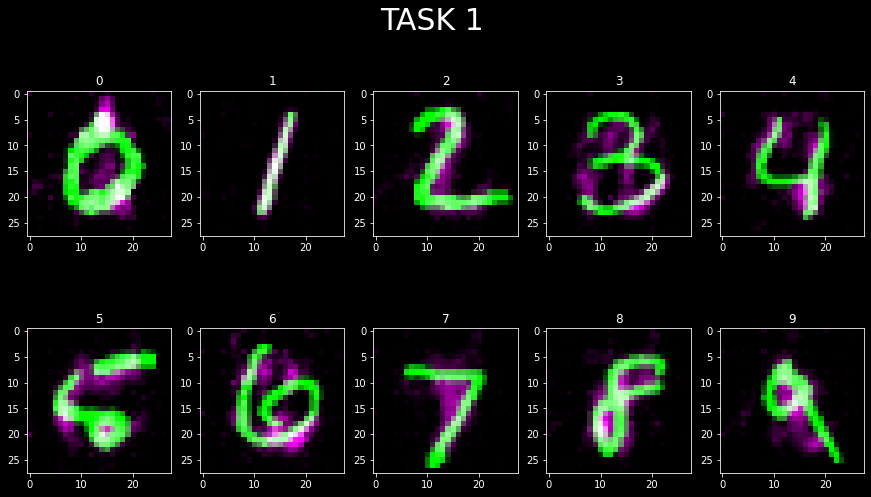

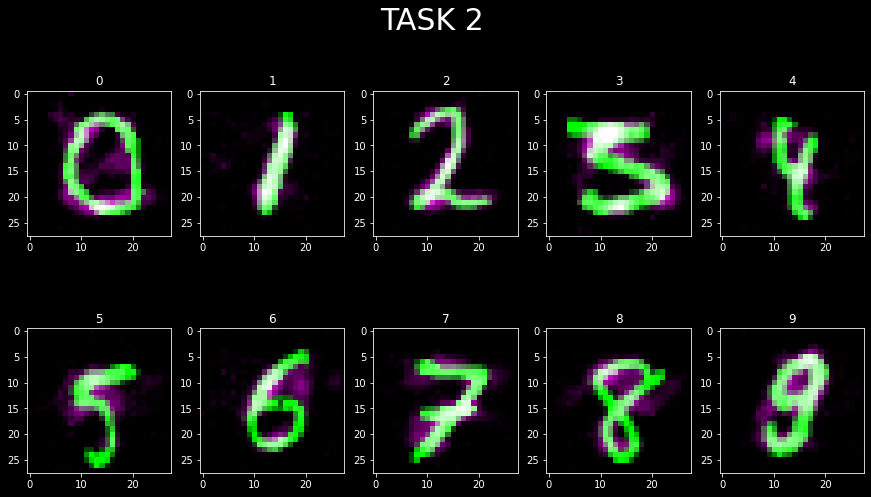

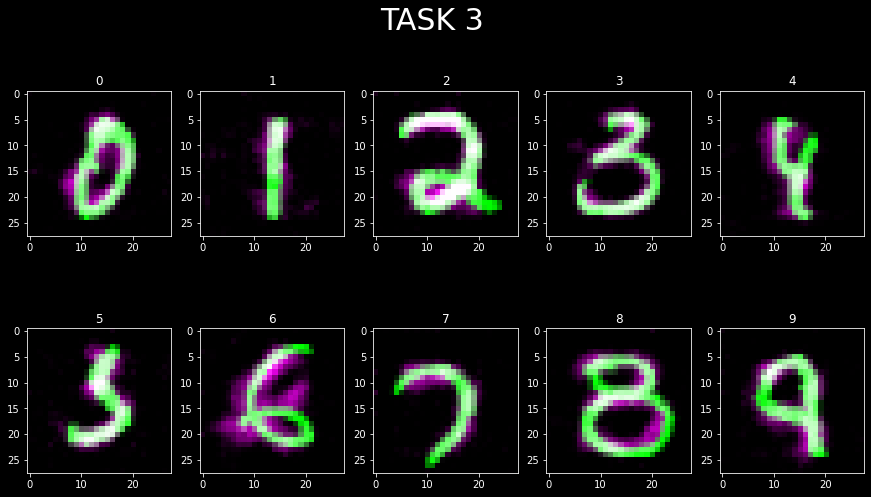

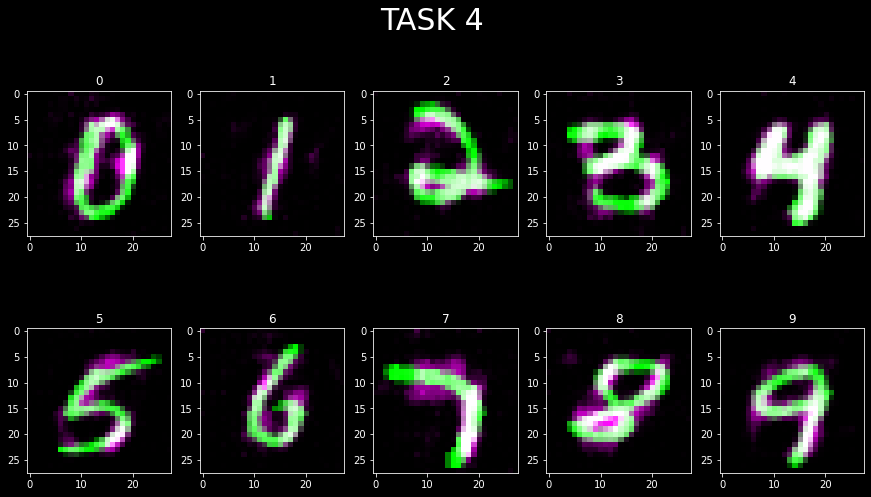

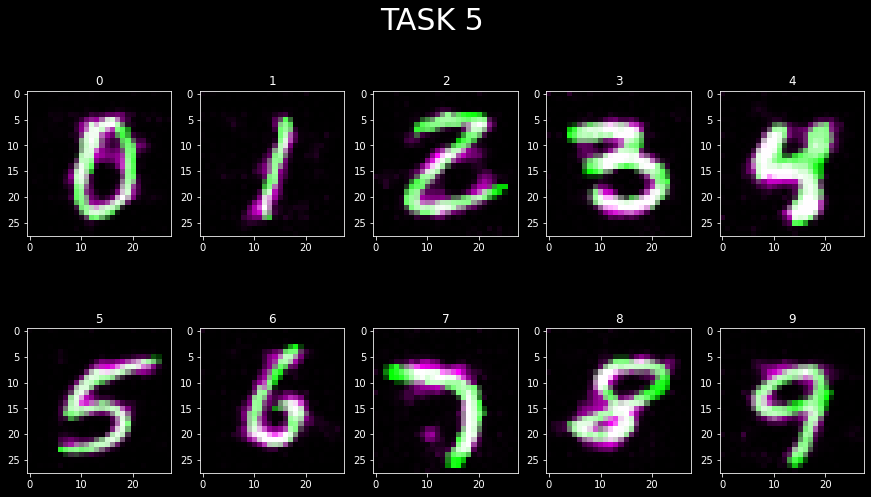

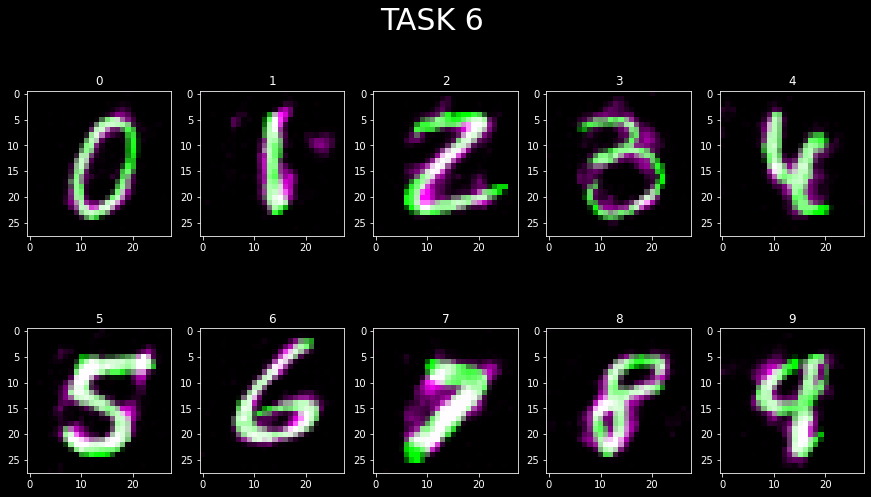

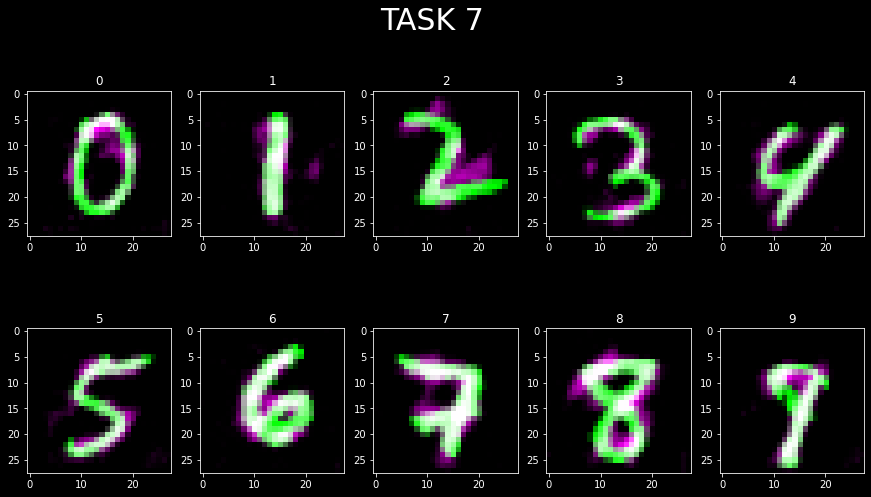

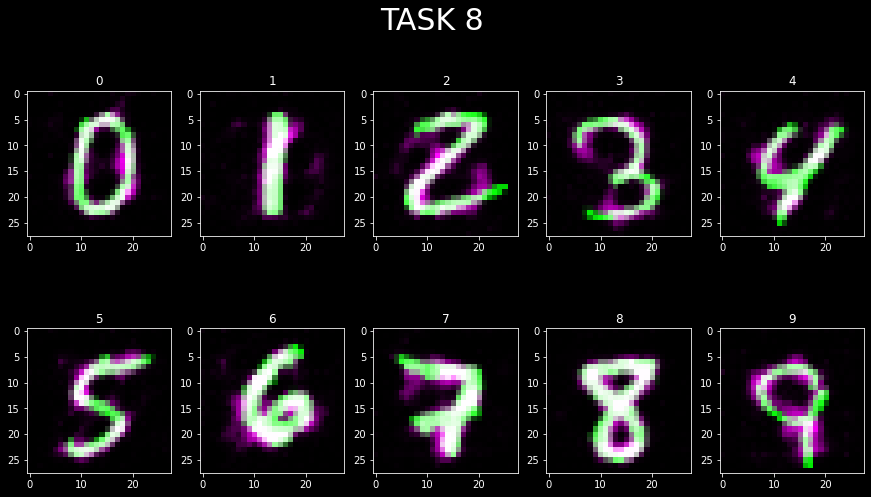

In [93]:
show_exp_images(exp, True)
